In [1]:
%%capture
!pip install spacy
!pip install einops
!pip install wandb
!python -m spacy download en
!python -m spacy download de

In [2]:
import os
import copy
import io
from typing import List, Optional
import math

import torch
from torch import nn, Tensor, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F

from einops import rearrange

import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
torch.manual_seed(1);

In [80]:
%%capture
import wandb
wandb.login()

### Data preparation

This section just follows https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html, for now.

In [6]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

In [7]:
train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

In [8]:
train_filepaths

['/content/.data/train.de', '/content/.data/train.en']

In [9]:
de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [10]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for line in f:
      counter.update(tokenizer(line))
  vcab = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
  vcab.set_default_index(vcab['<unk>'])
  return vcab

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

In [11]:
def preprocess(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []

  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)], dtype=torch.long)
    en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)], dtype=torch.long)
    data.append((de_tensor, en_tensor))
  return data

In [12]:
train_data = preprocess(train_filepaths)
val_data = preprocess(val_filepaths)
test_data = preprocess(test_filepaths)

In [13]:
len(train_data)

29000

In [14]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

In [15]:
def gen_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])],dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])],dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX, batch_first=True)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=True)
  return de_batch, en_batch

In [16]:
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_batch)
val_dl = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_batch)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=gen_batch)

In [17]:
src, target = next(iter(train_dl))
src.shape, target.shape

(torch.Size([128, 30]), torch.Size([128, 31]))

### Transformer model

With a lot of annotations to be cleaned up later

In [70]:
class MultiHeadAttention(nn.Module):
  def __init__(self,
               emb_dim: int,
               n_heads: int,
               is_cross: bool):
    super().__init__()
    assert emb_dim % n_heads == 0, "Embedding dimension must be divisble by number of heads"
    self.n_heads = n_heads
    self.emb_dim = emb_dim
    self.head_dim = emb_dim // n_heads
    self.is_cross = is_cross
    if not is_cross:
      # This projects each word vector into a new vector space (and we have n_heads amount of different vector spaces)
      self.kqv_project = nn.Linear(self.emb_dim, self.emb_dim * 3, bias=False) 
    else:
      self.kv_project = nn.Linear(self.emb_dim, self.emb_dim * 2, bias=False)
      self.q_project = nn.Linear(self.emb_dim, self.emb_dim, bias=False)
  
  def forward(self, 
              query: Tensor, # [bsz, q_seq_len, emb_dim]
              kv: Tensor, # [bsz, kv_seq_len, emb_dim]
              # The mask is a tensor where masked positions are -inf and unmasked are 0s
              # This is used for three cases currently: 
              # 1) attention mask for masking future tokens in decoder
              # 2) padding mask for encoder 
              # 3) padding mask for decoder (where we want to mask out tokens that correspond to paddings in kv)
              padding_mask: Optional[Tensor] = None, # [bsz, kv_seq_len]
              attn_mask: Optional[Tensor] = None, # [q_seq_len, q_seq_len] where q_seq_len == kv_seq_len
              ) -> Tensor:
    bsz, kv_seq_len, _ = kv.shape
    q_seq_len = query.shape[1]
    # print("Is cross? ", self.is_cross)
    # print(f"Query shape: {query.shape}\t kv shape: {kv.shape}\t mask shape: {mask.shape if mask is not None else 'None'}")

    if not self.is_cross: # self-attention
      assert q_seq_len == kv_seq_len
      kqv = self.kqv_project(kv) # [bsz, kv_seq_len, emb_dim * 3]
      # reshape for multi-head attention
      kqv = kqv.view(bsz, kv_seq_len, self.n_heads, self.head_dim * 3).transpose(1,2) # [bsz, n_heads, seq_len, head_dim * 3]
      K, Q, V = kqv.chunk(3,dim=-1) # K=Q=V => [bsz, n_heads, seq_len, head_dim]
    else:
      # K, V should come from encoder values, and Q from decoder
      kv_projected = self.kv_project(kv).view(bsz, kv_seq_len, self.n_heads, self.head_dim * 2).transpose(1,2)
      K, V = kv_projected.chunk(2, dim=-1) # [bsz, n_heads, kv_seq_len, head_dim]
      Q = self.q_project(query).view(bsz, q_seq_len, self.n_heads, self.head_dim).transpose(1,2) # [bsz, n_heads, q_seq_len, head_dim]

    # print(f"K shape: {K.shape}\t V shape: {V.shape}\t Q shape: {Q.shape}")
    attn_weights = torch.einsum('bhqd,bhkd->bhqk',[Q,K]) # [bsz, n_heads, q_seq_len, kv_seq_len] 
    attn_weights /= math.sqrt(self.head_dim) 

    if padding_mask is not None:
      attn_weights += padding_mask[:, None, None, :] 
    
    if attn_mask is not None:
      attn_weights += attn_mask[None, None, :, :]

    # softmax across last dim as it represents attention weight for each embedding vector in sequence
    softmax_attn = F.softmax(attn_weights, dim=-1) 
    out = torch.einsum('bhql,bhld->bhqd',[softmax_attn, V]) # [bsz, n_heads, q_seq_len, head_dim]
    out = out.transpose(1,2).reshape(bsz, q_seq_len, self.n_heads * self.head_dim) # [bsz, q_seq_len, emb_dim]
    return out


class PositionalEncoding(nn.Module):
  def __init__(self, emb_dim: int, max_seq_len: int = 5000):
    super().__init__()
    assert emb_dim % 2 == 0, "Embedding dimension must be divisble by 2"
    pos = torch.arange(max_seq_len)[:, None] # [seq_len, 1]
    evens = torch.arange(0,emb_dim,step=2) / emb_dim
    evens = 1 / 10000 ** evens
    evens = evens[None, :] # [1, ceil(emb_dim/2)]
    evens = pos * evens # [seq_len, ceil(emb_dim/2)]
    pe = rearrange([evens.sin(), evens.clone().cos()], 't h w -> h (w t)') # interleave even and odd parts
    self.register_buffer('pe', pe) # [max_seq_len, emb_dim]
  
  def forward(self, 
              src: Tensor # [bsz, seq_len, emb_dim]
              ) -> Tensor:
    out = src + self.pe[None,:src.size(1),:]
    return out

  def check_and_plot_pos_encoding(self): 
    # modified from tensorflow example (https://www.tensorflow.org/text/tutorials/transformer#positional_encoding)

    # Check the shape.
    print(self.pe.numpy().shape)

    # Plot the dimensions.
    plt.pcolormesh(self.pe.numpy(), cmap='RdBu')
    plt.gca().invert_yaxis()
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()


class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               emb_dim: int,
               hidden_dim: int,
               n_heads: int):
    super().__init__()
    self.attn = MultiHeadAttention(emb_dim, n_heads, is_cross=False)
    self.ff = nn.Sequential(
        nn.Linear(emb_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, emb_dim),
    ) # feed forward network

    # NOTE: why do we normalize across embedding dim only? 
    # see https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
    # and https://stackoverflow.com/questions/70065235/understanding-torch-nn-layernorm-in-nlp
    self.norm1 = nn.LayerNorm(emb_dim)
    self.norm2 = nn.LayerNorm(emb_dim)
    self.dropout = nn.Dropout(0.1)

  def forward(self, 
              xs: Tensor, # [bsz, seq_len, emb_dim],
              mask: Tensor, # [bsz, seq_len, seq_len]
              ) -> Tensor:

    ys = self.attn(query=xs, kv=xs, padding_mask=mask) 
    imm = self.norm1(self.dropout(ys) + xs)

    # [bsz,seq_len,emb_dim]
    out = self.ff(imm) 

    return self.norm2(self.dropout(out) +imm) # same dim as input xs


class TransformerEncoder(nn.Module):
    def __init__(self, 
                 emb_dim: int = 512, 
                 hidden_dim: int = 2048,
                 n_heads: int = 8,
                 depth: int = 8):
        super().__init__()
        encoder_block = TransformerEncoderBlock(emb_dim, hidden_dim, n_heads)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_block) for i in range(depth)])

    def forward(self, 
        xs: Tensor, # [bsz, seq_len, emb_dim] 
        mask: Tensor # [bsz, seq_len, seq_len]
        ) -> Tensor:
              
        out = xs

        for layer in self.layers:
          out = layer(out, mask)

        return out 

class TransformerDecoderBlock(nn.Module):
  def __init__(self,
               emb_dim: int,
               hidden_dim: int,
               n_heads: int):
    super().__init__()
    self.norm1 = nn.LayerNorm(emb_dim)
    self.norm2 = nn.LayerNorm(emb_dim)
    self.norm3 = nn.LayerNorm(emb_dim)
    self.masked_attn = MultiHeadAttention(emb_dim, n_heads, False)
    self.cross_attn = MultiHeadAttention(emb_dim, n_heads, True)
    self.ff = nn.Sequential(
        nn.Linear(emb_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, emb_dim),
    ) # feed forward network
    self.dropout = nn.Dropout(0.1)

  def forward(self, 
              xs: Tensor,  # [bsz, target_seq_len, emb_dim]
              encoder_output: Tensor,  # [bsz, src_seq_len, emb_dim]
              src_mask: Tensor, # [bsz, src_seq_len]
              trg_mask: Tensor # [trg_seq_len, trg_seq_len]
              ) -> Tensor:
    ys = self.masked_attn(query=xs, kv=xs, attn_mask=trg_mask) # [bsz, target_seq_len, emb_dim]
    xs2 = self.norm1(self.dropout(ys) + xs)
    ys2 = self.cross_attn(query=xs2, kv=encoder_output, padding_mask=src_mask)
    imm = self.norm2(self.dropout(ys2) + xs2)
    out = self.ff(imm)
    return self.norm2(self.dropout(out) + imm)


class TransformerDecoder(nn.Module):
  def __init__(self, 
               emb_dim: int = 512,
               hidden_dim: int = 2048,
               n_heads = 8, 
               depth: int = 8):
    super().__init__()
    decoder_block = TransformerDecoderBlock(emb_dim, hidden_dim, n_heads)
    self.layers = nn.ModuleList([copy.deepcopy(decoder_block) for i in range(depth)])

  def forward(self,
              xs: Tensor,  # [bsz,target_seq_len,emb_dim] (where target_seq_len=1 if inference time)
              encoder_output: Tensor, # [bsz,src_seq_len,emb_dim] 
              src_mask: Tensor, # [bsz, src_seq_len]
              trg_mask: Tensor, # [target_seq_len, target_seq_len]
              ) -> Tensor:
    out = xs  

    for layer in self.layers:
      out = layer(out, encoder_output, src_mask=src_mask, trg_mask=trg_mask)

    return out 


class Transformer(nn.Module):
  def __init__(self, 
               src_vocab_size: int, 
               trg_vocab_size: int,
               emb_dim: int = 512,
               hidden_dim: int = 2048,
               depth: int = 8,
               n_heads: int = 8,
               ):
    super().__init__()
    self.src_embedding = nn.Embedding(src_vocab_size, emb_dim)
    self.src_pos_encoding = PositionalEncoding(emb_dim)

    self.trg_embedding = nn.Embedding(trg_vocab_size, emb_dim)
    self.trg_pos_encoding = PositionalEncoding(emb_dim)

    self.encoder = TransformerEncoder(emb_dim, hidden_dim, n_heads, depth)
    self.decoder = TransformerDecoder(emb_dim, hidden_dim, n_heads, depth)
    self.project = nn.Linear(emb_dim, trg_vocab_size)
  
  def forward(self, 
              src: Tensor, # [bsz, src_seq_len]
              src_padding_mask: Tensor, # [bsz, src_seq_len] -> it can't be [bsz,seq_len,seq_len] because of how shapes work out
              trg: Tensor, # [bsz, target_seq_len]
              trg_mask: Tensor, # [target_seq_len, target_seq_len]
              ) -> Tensor:
    encoder_output = self.encode(src, src_padding_mask)
    return self.decode(trg, encoder_output, src_mask=src_padding_mask, trg_mask=trg_mask) # [bsz, target_seq_len, vocab_size]
  
  def encode(self, src:Tensor, mask: Tensor) -> Tensor:
    src_embeds_batch = self.src_embedding(src) # [bsz, src_seq_len, emb_dim]
    src_embeds_batch = self.src_pos_encoding(src_embeds_batch)
    out = self.encoder(src_embeds_batch, mask)
    return out

  def decode(self, trg: Tensor, encoder_output: Tensor, src_mask: Tensor, trg_mask: Tensor) -> Tensor:
    trg_embeds_batch = self.trg_embedding(trg)
    # print("target tensor dim: ", trg.shape)
    trg_embeds_batch = self.trg_pos_encoding(trg_embeds_batch)
    out = self.decoder(trg_embeds_batch, encoder_output, src_mask=src_mask, trg_mask=trg_mask)
    # print("actual tensor dim: ", out.shape)
    projected_out = self.project(out) # [bsz, trg_seq_len, vocab_size]
    # print("projected_out dim: ", projected_out.shape)
    probs = F.softmax(projected_out, dim=-1) # [bsz, trg_seq_len, vocab_size]
    # print("probs dim: ", probs.shape)
    return probs


In [71]:
class WarmingLRScheduler(optim.lr_scheduler._LRScheduler):
  def __init__(self, 
               optimizer: optim.Optimizer, 
               warming_steps: int, 
               emb_dim: int,
               last_epoch:int = -1,
               verbose: bool = False):
    self.optimizer = optimizer
    self.warming_steps = warming_steps
    self.emb_dim = emb_dim
    self.step_num = 1
    super(WarmingLRScheduler, self).__init__(optimizer)
  
  def get_lr(self) -> List[float]:
    new_lr = self.emb_dim**(-0.5) * min(self._step_count**(-0.5), self._step_count * self.warming_steps**(-1.5))
    return [new_lr for _ in self.optimizer.param_groups]


In [72]:
# Most of details can be found in original paper
EMB_DIM = 512
HIDDEN_DIM = 2048
LAYER_DEPTH = 6
NUM_HEADS = 8
NUM_WARMING_STEPS = 4000
NUM_EPOCHS = 30

model = Transformer(
    src_vocab_size=len(de_vocab),
    trg_vocab_size=len(en_vocab),
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    depth=LAYER_DEPTH,
    n_heads=NUM_HEADS,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), eps=1e-9)
lr_scheduler = WarmingLRScheduler(optimizer, NUM_WARMING_STEPS, EMB_DIM)

(4096, 512)


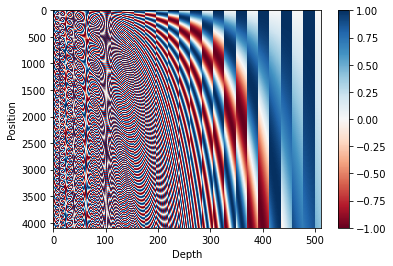

In [73]:
PositionalEncoding(512, 4096).check_and_plot_pos_encoding()

In [74]:
len(de_vocab), len(en_vocab)

(19215, 10838)

In [42]:
en_vocab.get_itos()[:4]

['<unk>', '<pad>', '<bos>', '<eos>']

In [43]:
def idx_to_words(indices: List[int], vocab: torchtext.vocab.Vocab) -> List[str]:
  return [vocab.get_itos()[idx] for idx in indices]

In [75]:
def create_decoder_mask(seq_len: int) -> Tensor:
  mask = torch.zeros(seq_len, seq_len).to(device)
  mask_indices = torch.arange(seq_len)[None, :] > torch.arange(seq_len)[:, None] 
  mask[mask_indices] = float('-inf')  
  return mask


def create_padding_mask(xs: Tensor, # [bsz, seq_len]
                        pad_idx: int 
                        ) -> Tensor:
  mask = torch.zeros(xs.shape).to(device)
  mask_indices = xs == pad_idx
  mask[mask_indices] = float('-inf')
  return mask

def create_padding_mask_old(xs: Tensor, # [bsz, seq_len]
                        pad_idx: int 
                        ) -> Tensor:
  bsz, seq_len = xs.shape
  mask = torch.zeros(bsz, seq_len, seq_len) # [bsz, seq_len, seq_len]
  mask_indices = xs == pad_idx
  mask[mask_indices, :] = float('-inf')
  mask = mask.permute(0,2,1)
  mask[mask_indices, :] = float('-inf')
  return mask.permute(0,2,1)

In [76]:
# NOTE: although this means that softmax of the last row of the second matrix will mean 1/3 for each cell,
# This doesn't matter because we do not include the PAD_IDX in the final calculation of loss using nn.CrossEntropyLoss()
# See https://stats.stackexchange.com/questions/598239/how-is-padding-masking-considered-in-the-attention-head-of-a-transformer
create_padding_mask_old(torch.Tensor([[0,2,1],[1,2,1]]), PAD_IDX)

tensor([[[0., 0., -inf],
         [0., 0., -inf],
         [-inf, -inf, -inf]],

        [[-inf, -inf, -inf],
         [-inf, 0., -inf],
         [-inf, -inf, -inf]]])

In [46]:
create_padding_mask(torch.Tensor([[0,2,1],[1,2,1]]), PAD_IDX)

tensor([[0., 0., -inf],
        [-inf, 0., -inf]], device='cuda:0')

In [ ]:
wandb.init(
    project="transformers-train",
    config={
    "num_heads": NUM_HEADS,
    "layer_depth": LAYER_DEPTH,
    "hidden_dim": HIDDEN_DIM,
    "epochs": NUM_EPOCHS,
    "num_warning_steps": NUM_WARMING_STEPS,
    "emb_dim": EMB_DIM,
    "dropout": True,
    }
)


In [77]:
def train(model: nn.Module, optimizer: optim.Optimizer) -> float:
  running_loss = 0.0
  num_sentence_pairs = 0

  for idx, (src, target) in enumerate(train_dl):
    # Move to GPU
    target = target.to(device)
    src = src.to(device)

    # src is german, target is english
    target_input = target[:,:-1] # Shifted left
    target_predict = target[:,1:] # Shifted right

    # print("target_predict shape: ", target_predict.shape)

    # each mini batch [bsz, seq_len] => seq_len changes (and bsz too, for last)
    src_seq_len = src.shape[1]
    target_seq_len = target_input.shape[1]

    # Create a square mask with diagonals (and left side) filled with -inf
    target_mask = create_decoder_mask(target_seq_len) # [target_seq_len, target_seq_len] 
    src_mask = create_padding_mask(src, PAD_IDX) # [bsz, src_seq_len, src_seq_len]

    probs = model(src, src_mask, target_input, target_mask) # [bsz, target_seq_len, target_vocab_size]
    preds = probs.argmax(dim=-1) # [bsz, target_seq_len]

    # cross-entropy loss expects input dim to be (bsz, target_vocab_size, seq_len) but currently it's (bsz, seq_len, target_vocab_size), let's reshape
    probs = probs.permute(0, 2, 1) 

    training_loss = criterion(probs, target_predict)

    optimizer.zero_grad()
    training_loss.backward()

    running_loss += training_loss.item()
    num_sentence_pairs += src.size(0) # batch size, should be 128 most of the time
    
    optimizer.step()

    # Diagnostic logging
    if idx % 49 == 0:
      
      print("German: ", idx_to_words(src[0].tolist(), de_vocab))
      print("English (actual): ", idx_to_words(target_predict[0].tolist(), en_vocab))
      print("English (predicted): ", idx_to_words(preds[0].tolist(), en_vocab))
      
      print(f"[epoch {epoch:3d}][{idx+1:3d}/{(len(train_dl)):3d} batches][loss/sentence:{running_loss/(idx+1): 5.2f}]")
      wandb.log({'train_loss': training_loss.item()})

  
  return running_loss

In [78]:
def evaluate(model: nn.Module, max_seq_len: int):
  model.eval()
  with torch.no_grad():
    val_src = next(iter(val_dl))[0][0].unsqueeze() # [1,src_seq_len]
    memory = model.encode(val_src)
    xs = torch.zeros(1,1).fill_(BOS_IDX).type_as(val_src.data) # [1,1]

    for i in range(max_seq_len):
      probs = model.decode(xs, memory, mask=None) # [1, seq_len,target_vocab_size]
      preds = probs.argmax(dim=-1) # [1,seq_len]
      assert preds.shape[0] == 1 and preds.shape[1] == 1
      xs = preds


In [ ]:
import time

for epoch in range(1, NUM_EPOCHS + 1):
  epoch_start = time.time()

  # Start of training 
  train_loss = train(model, optimizer)
  wandb.log({'step': lr_scheduler._step_count, 'lr': optimizer.param_groups[0]['lr']})
  lr_scheduler.step()
  print('-' * 89)
  print(f'| end of epoch {epoch:3d} | time {time.time()-epoch_start:5.2f}s | train_loss {train_loss:8.3f} | valid_loss: TODO |')
  print('-' * 89)

In [ ]:
%%capture
wandb.finish()

In [ ]:
# Evaluate model greedily
evaluate(model)